In [1]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import glob
%matplotlib inline

sns.set(rc={'figure.figsize':(9, 3)})
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 600
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Lulesh Data

In [12]:

def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

data = []

for f in glob.glob(os.path.join(BASE_PATH, f'data/baseline/ault/lulesh_27/lulesh_*.out')):

    with open(f, 'r') as fp:
        for line in lines_that_start_with("Elapsed time", fp):
            size = int(f.split('_')[-2])
            data.append([size, float(line.split()[-2])])
                
normal_lulesh_ault = pd.DataFrame(data=data, columns=['lulesh_size', 'time'])
normal_lulesh_ault['system'] = 'ault'
normal_lulesh_ault['type'] = 'baseline'
normal_lulesh_ault['benchmark'] = 'lulesh'
normal_lulesh_ault['application'] = 'lulesh'
#normal_lulesh_ault['benchmark-type'] = normal_lulesh_ault.apply(lambda row: f"({row['benchmark'].upper()}, {row['application'].upper()}, {row['size']})", axis=1)
normal_lulesh_ault['ranks'] = 27
normal_lulesh_ault['nodes'] = 1

data = []
for f in glob.glob(os.path.join(BASE_PATH, f'data/baseline/ault/milc_32/milc_32/milc_*.out')):

    with open(f, 'r') as fp:
        for line in lines_that_start_with("Elapsed total time", fp):
            size = int(f.split('_')[-2])
            data.append([size, float(line.split()[-1])])
            
normal_milc_ault = pd.DataFrame(data=data, columns=['lulesh_size', 'time'])
normal_milc_ault['system'] = 'ault'
normal_milc_ault['type'] = 'baseline'
normal_milc_ault['benchmark'] = 'milc'
normal_milc_ault['application'] = 'milc'
#normal_milc_ault['benchmark-type'] = normal_milc_ault.apply(lambda row: f"({row['benchmark'].upper()}, {row['application'].upper()}, {row['size']})", axis=1)
normal_milc_ault['ranks'] = 32
normal_milc_ault['nodes'] = 1

#baseline_data = pd.concat([normal_lulesh_ault, normal_milc_ault])
#print(baseline_data)
#print(lulesh_time.groupby(['lulesh_size']).mean())
#print(lulesh_time.groupby(['lulesh_size']).std() / lulesh_time.groupby(['lulesh_size']).mean())


# New LULESH data

In [13]:
data = []
for type in ['read', 'write']:

    for pause in [100000, 10000, 1000, 250000, 25000, 500000, 50000, 5000]:

        for f in glob.glob(os.path.join(BASE_PATH, f'data/colocation_rma/lulesh/{type}_{pause}_10485760/lulesh_*.out')):

            with open(f, 'r') as fp:
                for line in lines_that_start_with("Elapsed time", fp):
                    size = int(f.split('_')[-2])
                    data.append([type, pause, size, float(line.split()[-2])])
                
rma_ault = pd.DataFrame(data=data, columns=['type', 'pause', 'lulesh_size', 'time'])
#rma_ault['benchmark-type'] = rma_ault.apply(lambda row: f"({row['type'].capitalize()}, {str(int(row['pause']/1000)).upper()} ms)", axis=1)
rma_ault['benchmark-type'] = rma_ault.apply(lambda row: f"({row['type'].capitalize()[0:1]}, {str(int(row['pause']/1000)).upper()} ms)", axis=1)

rma_ault.sort_values('benchmark-type', inplace=True)

In [14]:

#rma_ault['new-index'] = rma_ault.apply(lambda row: f"({row['type'].capitalize()}, {row['pause']/1000.0})", axis=1)
mean_colocated_lulesh = rma_ault.groupby(['lulesh_size', 'benchmark-type']).mean().reset_index()
median_colocated_lulesh = rma_ault.groupby(['lulesh_size', 'benchmark-type']).median().reset_index()
dev_colocated_lulesh = rma_ault.groupby(['lulesh_size', 'benchmark-type']).std().reset_index()
mean_lulesh = normal_lulesh_ault.groupby(['lulesh_size']).mean().reset_index()
median_lulesh = normal_lulesh_ault.groupby(['lulesh_size']).median().reset_index()
dev_lulesh = normal_lulesh_ault.groupby(['lulesh_size']).std().reset_index()

#print(mean_lulesh)
#print(mean_colocated_lulesh)

df1 = mean_colocated_lulesh.set_index('lulesh_size')
df2 = mean_lulesh.set_index('lulesh_size')
df1['original_time'] = df2['time'].reindex(df1.index)
df1['slowdown'] = df1['time'] / df1['original_time']
df1['original_dev'] = dev_lulesh.set_index('lulesh_size')['time'].reindex(df1.index)
df1['dev'] = dev_colocated_lulesh.set_index('lulesh_size')['time'].reindex(df1.index)
df1['slowdown_dev'] = np.sqrt((df1['original_dev'] / df1['original_time'])**2 + (df1['dev'] / df1['time'])**2)
print(df1)

df1.reset_index(inplace=True)
df1['slowdown'] = (df1['slowdown']-1)*100
df1['slowdown_dev'] = df1['slowdown_dev']*100
from natsort import natsort_keygen


df1.sort_values('benchmark-type', inplace=True, key=natsort_keygen())
#df1['new-index'] = df1.apply(lambda row: row['benchmark-type']. f"({row['type'].capitalize()}, {row['pause']/1000.0})", axis=1)

            benchmark-type     pause        time  original_time  slowdown  \
lulesh_size                                                                 
10               (R, 1 ms)    1000.0    4.500014       4.490387  1.002144   
10              (R, 10 ms)   10000.0    4.493721       4.490387  1.000743   
10             (R, 100 ms)  100000.0    4.495624       4.490387  1.001166   
10              (R, 25 ms)   25000.0    4.496506       4.490387  1.001363   
10             (R, 250 ms)  250000.0    4.495110       4.490387  1.001052   
...                    ...       ...         ...            ...       ...   
25              (W, 25 ms)   25000.0  184.331016     179.304989  1.028031   
25             (W, 250 ms)  250000.0  184.224744     179.304989  1.027438   
25               (W, 5 ms)    5000.0  184.810344     179.304989  1.030704   
25              (W, 50 ms)   50000.0  184.257636     179.304989  1.027621   
25             (W, 500 ms)  500000.0  184.211211     179.304989  1.027362   

# Plot LULESH

In [15]:

def barplot_err(x, y, xerr=None, yerr=None, data=None, **kwargs):

    _data = []
    for _i in data.index:

        _data_i = pd.concat([data.loc[_i:_i]]*3, ignore_index=True, sort=False)
        _row = data.loc[_i]
        if xerr is not None:
            _data_i[x] = [_row[x]-_row[xerr], _row[x], _row[x]+_row[xerr]]
        if yerr is not None:
            _data_i[y] = [_row[y]-_row[yerr], _row[y], _row[y]+_row[yerr]]
        _data.append(_data_i)

    _data = pd.concat(_data, ignore_index=True, sort=False)

    _ax = sns.barplot(x=x,y=y,data=_data,ci='sd',**kwargs)

    return _ax

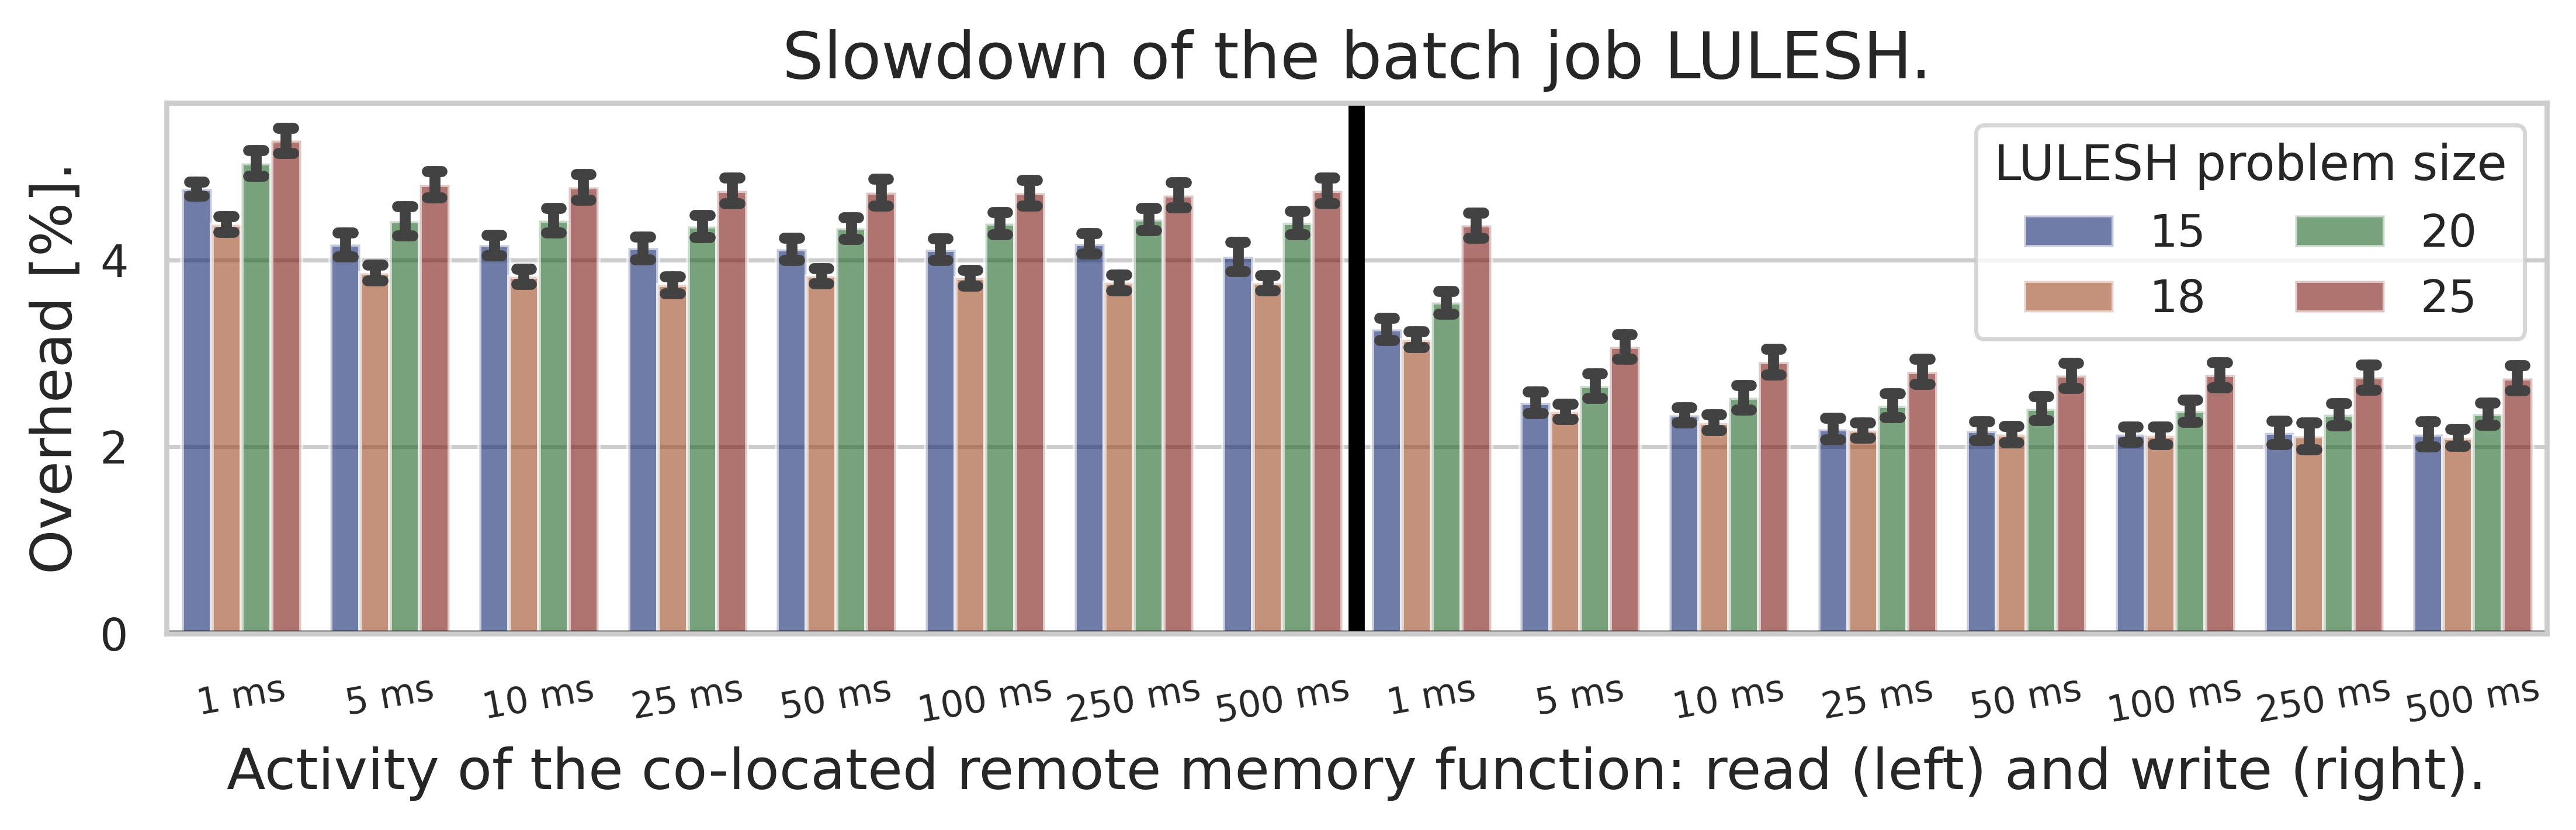

In [16]:

df2 = df1.loc[~(df1['lulesh_size'] == 10)]

sns.set_style("whitegrid")
fig = plt.figure(figsize=(9,3))
ax = fig.gca()
#g = sns.barplot(
#    data=df1.reset_index(),
#    x="type", y="slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #size=.5,#height=6,
#    ax=ax
#)
g = barplot_err(y="slowdown", x="benchmark-type", yerr="slowdown_dev", hue="lulesh_size",
                data=df2,palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('Activity of the co-located remote memory function: read (left) and write (right).',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job LULESH.',fontsize=16)
g.legend(title='LULESH problem size', ncol=2)
g.axhline(y=0, color='black', linestyle='-')

ticks=[]
labels=[]
for tick in g.get_xticklabels():
    ticks.append(tick.get_position()[0])
    labels.append(tick.get_text().split(',')[1][1:-1])
plt.xticks(ticks,labels,fontsize=9, rotation=10)
#plt.xtickslabels(['a'])


plt.annotate("Baseline LULESH execution times:\n24.3, 48.4, 74.2, 191.8 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(1, -2),  #xycoords='data',
            xytext=(1.5, -3.5), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)

plt.axvline(7.5, 0,5,color='black',linewidth=4)
plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig(os.path.join('plots', "colocation_rma_lulesh.pdf"),bbox_inches='tight',pad_inches = 0, transparent=False)


# Load MILC data

In [18]:
data = []
for type in ['read', 'write']:

    for pause in [100000, 10000, 1000, 250000, 25000, 500000, 50000, 5000]:

        for f in glob.glob(os.path.join(BASE_PATH, f'data/colocation_rma/milc/{type}_{pause}_10485760/milc_*.out')):

            with open(f, 'r') as fp:
                for line in lines_that_start_with("Elapsed total time", fp):
                    size = int(f.split('_')[-2])
                    data.append([type, pause, size, float(line.split()[-1])])
                
rma_ault = pd.DataFrame(data=data, columns=['type', 'pause', 'lulesh_size', 'time'])
#rma_ault['benchmark-type'] = rma_ault.apply(lambda row: f"({row['type'].capitalize()}, {str(int(row['pause']/1000)).upper()} ms)", axis=1)
rma_ault['benchmark-type'] = rma_ault.apply(lambda row: f"({row['type'].capitalize()[0:1]}, {str(int(row['pause']/1000)).upper()} ms)", axis=1)

rma_ault.sort_values('benchmark-type', inplace=True)


#rma_ault['new-index'] = rma_ault.apply(lambda row: f"({row['type'].capitalize()}, {row['pause']/1000.0})", axis=1)
mean_colocated_lulesh = rma_ault.groupby(['lulesh_size', 'benchmark-type']).mean().reset_index()
median_colocated_lulesh = rma_ault.groupby(['lulesh_size', 'benchmark-type']).median().reset_index()
dev_colocated_lulesh = rma_ault.groupby(['lulesh_size', 'benchmark-type']).std().reset_index()
mean_lulesh = normal_milc_ault.groupby(['lulesh_size']).mean().reset_index()
median_lulesh = normal_milc_ault.groupby(['lulesh_size']).median().reset_index()
dev_lulesh = normal_milc_ault.groupby(['lulesh_size']).std().reset_index()

#print(mean_lulesh)
#print(mean_colocated_lulesh)

df1 = mean_colocated_lulesh.set_index('lulesh_size')
df2 = mean_lulesh.set_index('lulesh_size')
df1['original_time'] = df2['time'].reindex(df1.index)
df1['slowdown'] = df1['time'] / df1['original_time']
df1['original_dev'] = dev_lulesh.set_index('lulesh_size')['time'].reindex(df1.index)
df1['dev'] = dev_colocated_lulesh.set_index('lulesh_size')['time'].reindex(df1.index)
df1['slowdown_dev'] = np.sqrt((df1['original_dev'] / df1['original_time'])**2 + (df1['dev'] / df1['time'])**2)
print(df1)

df1.reset_index(inplace=True)
df1['slowdown'] = (df1['slowdown']-1)*100
df1['slowdown_dev'] = df1['slowdown_dev']*100
from natsort import natsort_keygen


df1.sort_values('benchmark-type', inplace=True, key=natsort_keygen())
#df1['new-index'] = df1.apply(lambda row: row['benchmark-type']. f"({row['type'].capitalize()}, {row['pause']/1000.0})", axis=1)

            benchmark-type     pause        time  original_time  slowdown  \
lulesh_size                                                                 
32               (R, 1 ms)    1000.0   51.088032      50.728608  1.007085   
32              (R, 10 ms)   10000.0   50.837041      50.728608  1.002138   
32             (R, 100 ms)  100000.0   50.628134      50.728608  0.998019   
32              (R, 25 ms)   25000.0   50.659717      50.728608  0.998642   
32             (R, 250 ms)  250000.0   50.651601      50.728608  0.998482   
...                    ...       ...         ...            ...       ...   
128             (W, 25 ms)   25000.0  233.407285     218.200487  1.069692   
128            (W, 250 ms)  250000.0  232.768408     218.200487  1.066764   
128              (W, 5 ms)    5000.0  235.652554     218.200487  1.079982   
128             (W, 50 ms)   50000.0  232.532648     218.200487  1.065683   
128            (W, 500 ms)  500000.0  232.497603     218.200487  1.065523   

In [35]:
print(df1)

for index, row in df1.iterrows():
    
    bench = row['benchmark-type']
    bench_type = bench.split(',')[0][1:]
    freq = int(bench.split(',')[1].split(' ')[1])
    
    #print(bench)
    print(f'Type: {bench_type}, reading {1000/freq*10}, size {row["lulesh_size"]}, overhead {row["slowdown"]}')

    lulesh_size benchmark-type     pause        time  original_time  \
0            32      (R, 1 ms)    1000.0   51.088032      50.728608   
16           64      (R, 1 ms)    1000.0  110.544999     105.031156   
32           96      (R, 1 ms)    1000.0  164.833431     150.403188   
48          128      (R, 1 ms)    1000.0  246.973198     218.200487   
53          128      (R, 5 ms)    5000.0  237.414140     218.200487   
..          ...            ...       ...         ...            ...   
28           64    (W, 250 ms)  250000.0  107.791606     105.031156   
31           64    (W, 500 ms)  500000.0  107.054060     105.031156   
15           32    (W, 500 ms)  500000.0   50.586939      50.728608   
47           96    (W, 500 ms)  500000.0  157.969999     150.403188   
63          128    (W, 500 ms)  500000.0  232.497603     218.200487   

     slowdown  original_dev       dev  slowdown_dev  
0    0.708523      0.143358  0.132497      0.383567  
16   5.249721      1.001065  0.150112  

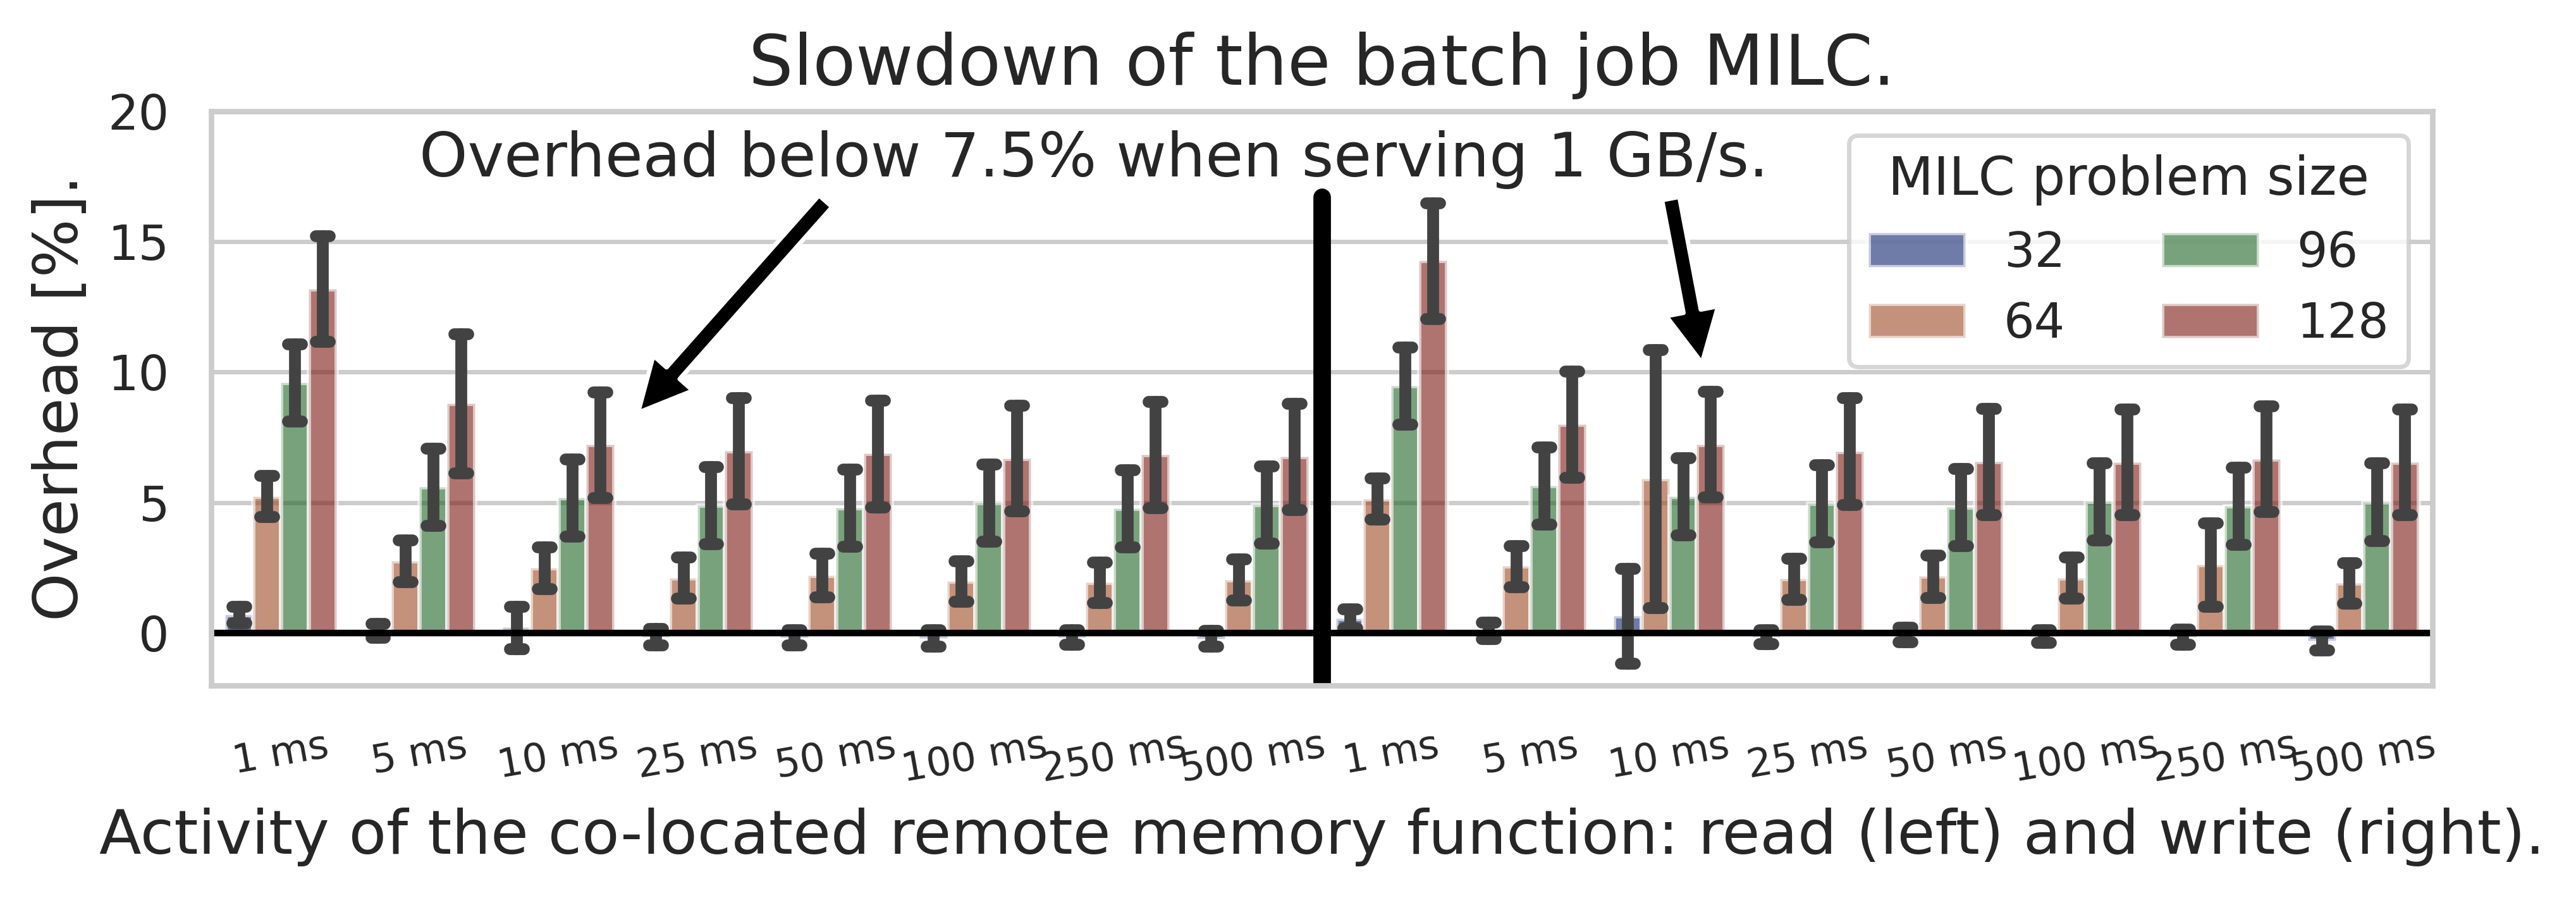

In [63]:

df2 = df1.loc[~(df1['lulesh_size'] == 10)]

sns.set_style("whitegrid")
fig = plt.figure(figsize=(8,3))
ax = fig.gca()
#g = sns.barplot(
#    data=df1.reset_index(),
#    x="type", y="slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #size=.5,#height=6,
#    ax=ax
#)
g = barplot_err(y="slowdown", x="benchmark-type", yerr="slowdown_dev", hue="lulesh_size",
                data=df2,palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('Activity of the co-located remote memory function: read (left) and write (right).',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job MILC.',fontsize=16)
g.legend(title='MILC problem size', ncol=2)
g.axhline(y=0, color='black', linestyle='-')
g.set_ylim([-2, 20])

ticks=[]
labels=[]
for tick in g.get_xticklabels():
    ticks.append(tick.get_position()[0])
    labels.append(tick.get_text().split(',')[1][1:-1])
#print(ticks)
#print(labels)
plt.xticks(ticks,labels,fontsize=9, rotation=10)
#plt.xtickslabels(['a'])


plt.annotate(
    "Overhead below 7.5% when serving 1 GB/s.",         
    xytext=(1, 17.5), fontsize=14,       
    xy=(3, 7)
)
plt.annotate(
    "",         
    xytext=(4, 17), fontsize=14,       
    xy=(2.5, 8),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

plt.annotate(
    "",         
    xytext=(10, 17), fontsize=14,       
    xy=(10.25, 10),
    arrowprops=dict(facecolor='black', shrink=0.05)
#             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
#             xy=(1, -2),  #xycoords='data',
#            xytext=(1.5, -3.5), fontsize=14,
#    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)


plt.axvline(7.5, 0, 0.85, color='black',linewidth=4)
#plt.axvline(7.5, 0,5,color='black',linewidth=4)
#plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig(os.path.join('plots', "colocation_rma_milc.pdf"),bbox_inches='tight',pad_inches = 0, transparent=False)


# MILC Plot Poster

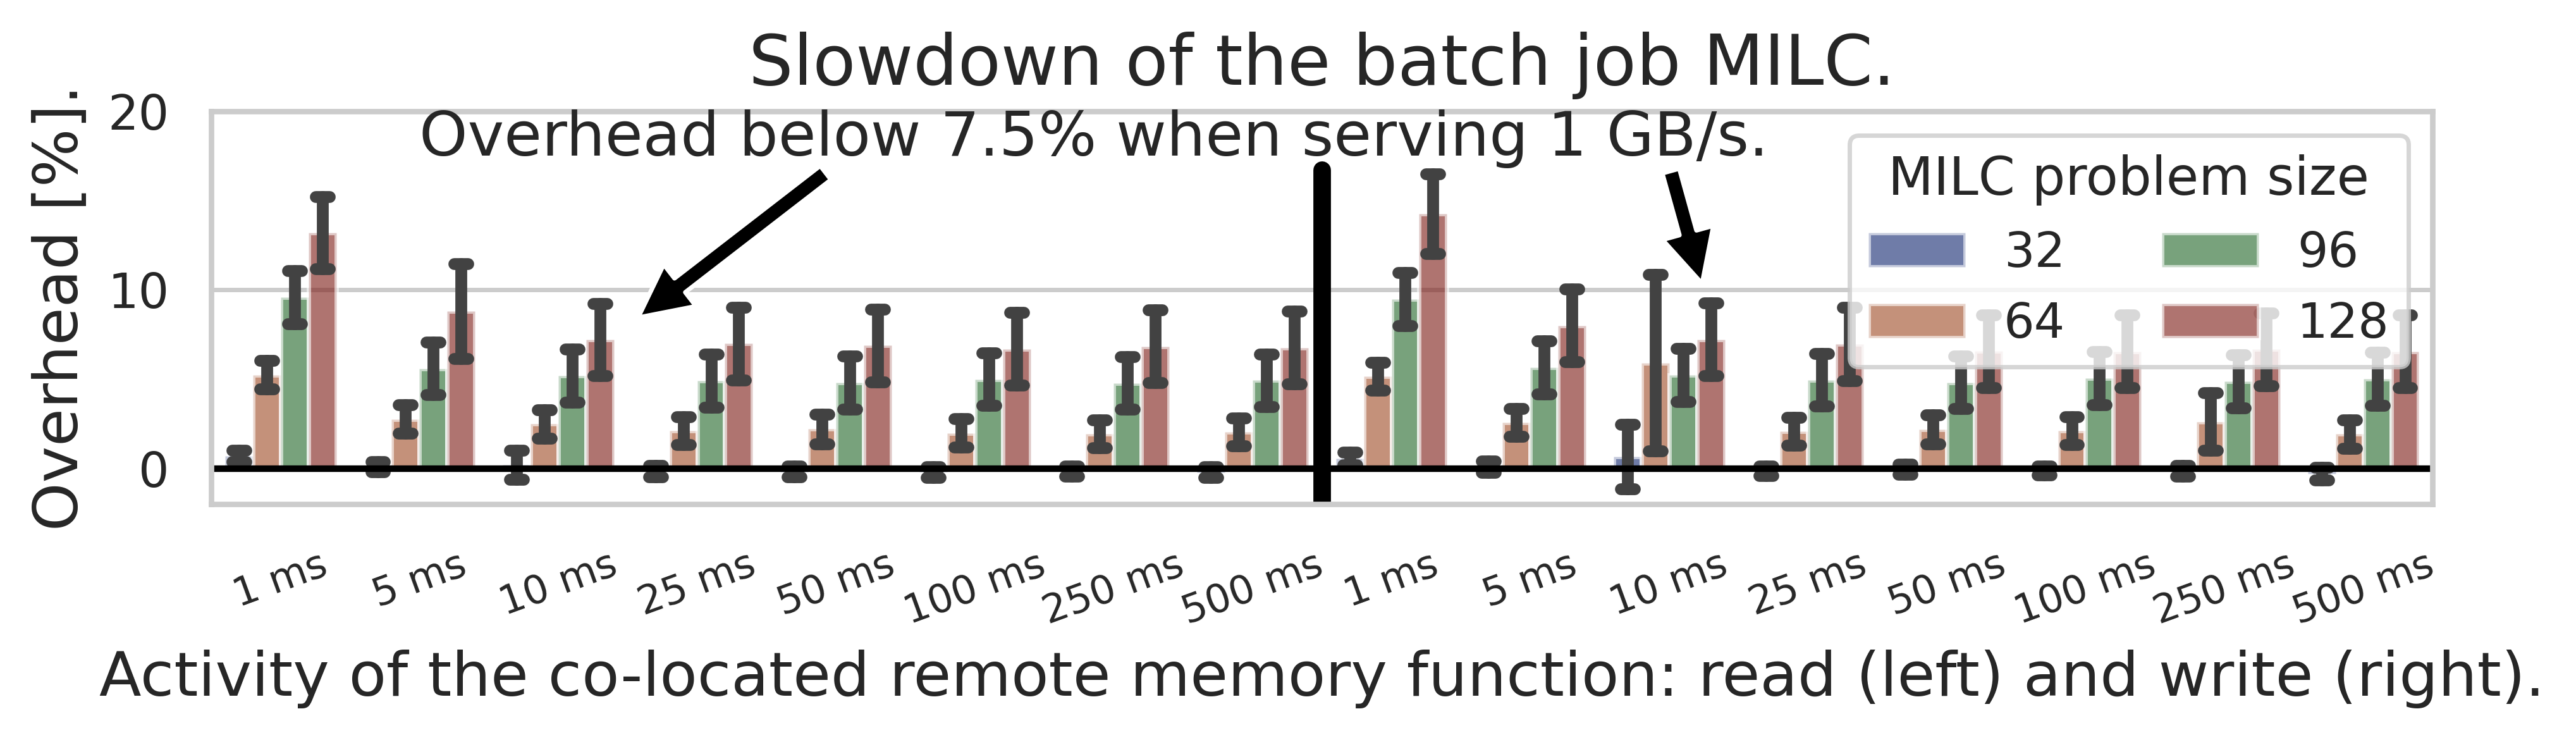

In [65]:

df2 = df1.loc[~(df1['lulesh_size'] == 10)]

sns.set_style("whitegrid")
fig = plt.figure(figsize=(9,2.5))
ax = fig.gca()
#g = sns.barplot(
#    data=df1.reset_index(),
#    x="type", y="slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #size=.5,#height=6,
#    ax=ax
#)
g = barplot_err(y="slowdown", x="benchmark-type", yerr="slowdown_dev", hue="lulesh_size",
                data=df2,palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('Activity of the co-located remote memory function: read (left) and write (right).',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job MILC.',fontsize=16)
g.legend(title='MILC problem size', ncol=2)
g.axhline(y=0, color='black', linestyle='-')
g.set_ylim([-2, 20])

ticks=[]
labels=[]
for tick in g.get_xticklabels():
    ticks.append(tick.get_position()[0])
    labels.append(tick.get_text().split(',')[1][1:-1])
#print(ticks)
#print(labels)
plt.xticks(ticks,labels,fontsize=9, rotation=20)
#plt.xtickslabels(['a'])


plt.annotate(
    "Overhead below 7.5% when serving 1 GB/s.",         
    xytext=(1, 17.5), fontsize=14,       
    xy=(3, 7)
)
plt.annotate(
    "",         
    xytext=(4, 17), fontsize=14,       
    xy=(2.5, 8),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

plt.annotate(
    "",         
    xytext=(10, 17), fontsize=14,       
    xy=(10.25, 10),
    arrowprops=dict(facecolor='black', shrink=0.05)
#             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
#             xy=(1, -2),  #xycoords='data',
#            xytext=(1.5, -3.5), fontsize=14,
#    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)


plt.axvline(7.5, 0, 0.85, color='black',linewidth=4)
#plt.axvline(7.5, 0,5,color='black',linewidth=4)
#plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig(os.path.join('plots', "colocation_rma_milc_poster.pdf"),bbox_inches='tight',pad_inches = 0, transparent=False)
